In [32]:
import torch 
import numpy as np
from pathlib import Path 
import random
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec 
import matplotlib.cm as cm 
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers.models.llama.modeling_llama import repeat_kv
from src.models import load_model_tokenizer, get_layers_heads
from src.model_wrapper import ModelWrapper
from src.to_numpy import to_numpy
import math

In [33]:
from src.dataset import load_data_batches

In [34]:
from src.hook import Hook, RecordHook, ZeroOutAttentionHeadHook, CompositeHook

In [35]:
dirname = "/data/tianyu/DormantHeads/figures"
import os

In [36]:
device = "cuda:0"
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)


In [37]:
model_name = "llama2-7B"
model, tokenizer = load_model_tokenizer(model_name, device_map=device)
num_layers, num_heads = get_layers_heads(model_name)
wrapper = ModelWrapper(model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


In [38]:
def visualize_attention_weights(attn_weights, layer, head, length=48, dataset_name="wikipedia", show_xlabel=True, show_sample_label=True, show_xticklabels=True, save_fn=None):
    attn_weights = to_numpy(attn_weights)
    B, H, N, _ = attn_weights.shape
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, B+1, width_ratios=[1] * B + [0.05])
    axes = [fig.add_subplot(gs[0, i]) for i in range(B)]
    fig.suptitle(f"{dataset_name.capitalize()} Data", fontsize=28)
    N = length
    

    for idx in range(B):
        attn_plot = attn_weights[idx, head][:length, :length]
        sns.heatmap(attn_plot, cmap="Blues", ax=axes[idx], mask=attn_plot == 0, cbar=False, vmin=0, vmax=1)
        if show_sample_label:
            axes[idx].set_title(f"Sample {idx}", fontsize=18)
        axes[idx].set_yticks(range(0, N, N // 3))
        if show_xticklabels:
            axes[idx].set_xticks(range(0, N, N // 3))
            axes[idx].set_xticklabels(range(0, N, N // 3), rotation=0)
        else:
            axes[idx].set_xticks([])
            axes[idx].set_xticklabels([])
        axes[idx].set_yticklabels(range(0, N, N // 3))

        for i in range(length):
            for j in range(i+1):
                axes[idx].add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=0.03))
    
    
    cbar_ax = fig.add_subplot(gs[:, -1])
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])

    # Add the colorbar
    fig.colorbar(sm, cax=cbar_ax)
    cbar_ax.set_yticks([0, 1])
    cbar_ax.set_yticklabels([0, 1])
    if show_xlabel:
        fig.text(0.5, -0.05, 'Key States', ha='center', fontsize=24)
    fig.text(-0.05, 0.5, 'Query States', va='center', rotation='vertical', fontsize=24)
    plt.tight_layout()
    if save_fn:
        plt.savefig(save_fn, dpi=500, bbox_inches="tight")

In [53]:
special_layer = 16
special_head = 25
import json
dataset_name = "wikipedia"
with open("/data/tianyu/massive-unlearning/dataset/RedPajama/wiki_texts.json") as f:
    batch = json.load(f)
inputs = tokenizer(batch, return_tensors="pt", truncation=True, max_length=64).input_ids.to(device)


In [54]:
hook = RecordHook(target_name="attn_weights", record_buffer=[], target_layers=[special_layer])
outputs = wrapper.forward(inputs[:3, :], hook=hook)

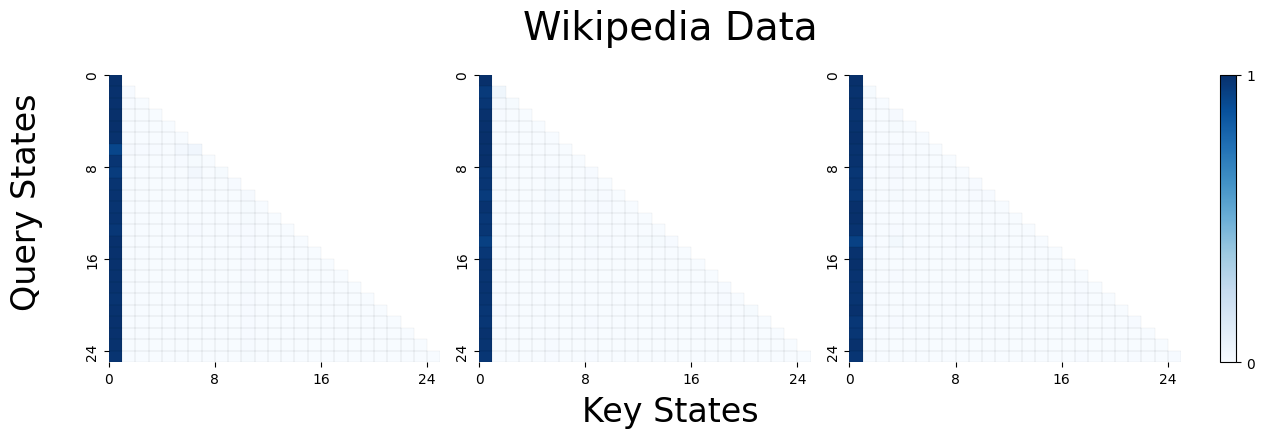

In [55]:
visualize_attention_weights(hook.record_buffer[0], special_layer, special_head, dataset_name=dataset_name, show_sample_label=False, show_xticklabels=True, save_fn=os.path.join(dirname, f"attn_{dataset_name}_head{special_head}.png"), length=25)

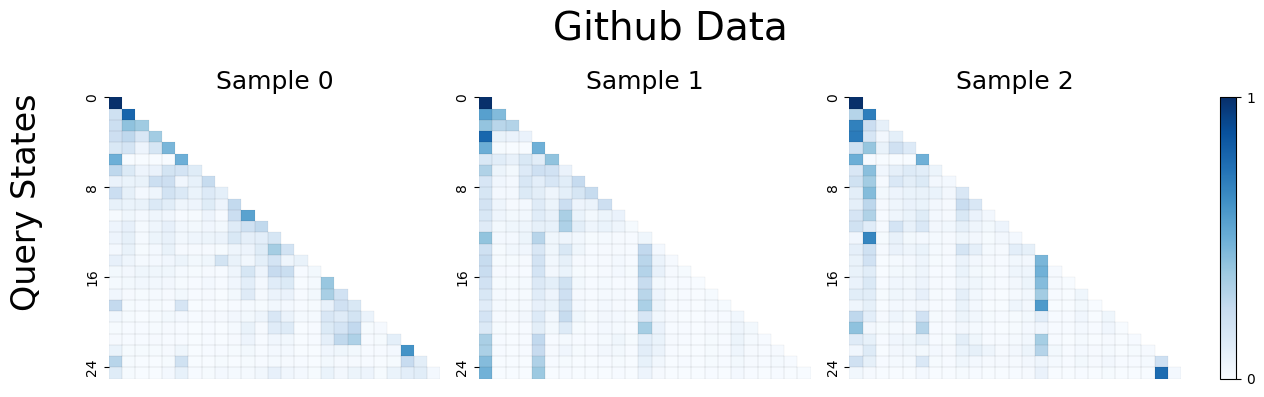

In [56]:
import json
dataset_name = "github"
with open("/data/tianyu/massive-unlearning/dataset/RedPajama/github_texts.json") as f:
    batch = json.load(f)
inputs = tokenizer(batch, return_tensors="pt", truncation=True, max_length=64).input_ids.to(device)
hook = RecordHook(target_name="attn_weights", record_buffer=[], target_layers=[special_layer])
outputs = wrapper.forward(inputs[:3, :], hook=hook)
visualize_attention_weights(hook.record_buffer[0], special_layer, special_head, dataset_name=dataset_name, show_xticklabels=False, show_xlabel=False, save_fn=os.path.join(dirname, f"attn_{dataset_name}_head{special_head}.png"), length=25)